In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import pickle
from lmfit.models import LinearModel, LorentzianModel
from scipy.signal import find_peaks

In [2]:
folder = r"Z:\P110143-phosphosulfides-Andrea\Data\Samples\mittma_0023_Cu\Raman"
files = os.listdir(folder)
files = [f for f in files if f.endswith('.txt')]
print(files)


['mittma_0023_BR_5sx5aq bl.txt', 'mittma_0023_BR_5sx5aq br.txt', 'mittma_0023_BR_5sx5aq br1.txt', 'mittma_0023_BR_5sx5aq tl.txt', 'mittma_0023_BR_5sx5aq tr.txt', 'mittma_0023_BR_5sx5aq.txt', 'mittma_0023_BR_raman_fit_results.txt']


In [3]:
# samples_to_analyse = ['bl', 'br', 'tc', 'tc-1mm', 'tl', 'tr', 'tr-2mm'] # 19 BR
# samples_to_analyse = ['bl', 'br', 'tl', 'tr', ''] # 19 FR
# samples_to_analyse = ['bl', 'br', 'tl', 'tr'] # 15 BL
# samples_to_analyse = ['bl', 'tr', ''] # 12 FL
# samples_to_analyse = ['bl', 'br', 'tl','tr', ''] # 11 BR and 22 BR
samples_to_analyse = ['bl', 'br1', 'tl', 'tr', ''] # 23 BR

sample_name= 'mittma_0023_BR'
filename= sample_name + '_5sx5aq '

,wavenumber,intensity
1014,-172.794922,7.058754
1013,-171.378906,5.295183
1012,-169.962891,26.481499
1011,-168.546875,14.126445
1010,-167.130859,24.726492
...,...,...
4,1123.490234,1468.795654
3,1124.654297,1496.978516
2,1125.818359,1480.060547
1,1126.982422,1422.314819


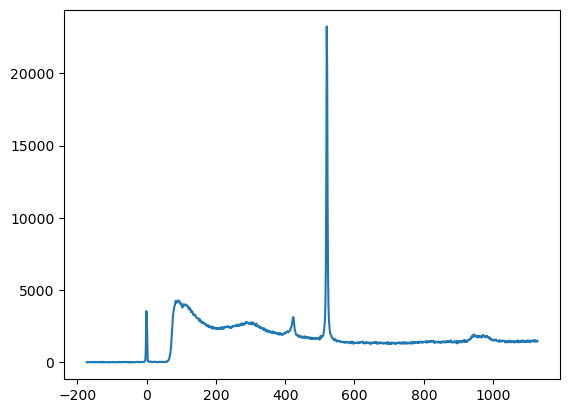

In [6]:
n=2
filepath= os.path.join(folder, filename + f'{samples_to_analyse[n]}.txt')
data = pd.read_csv(filepath, sep='\t', skiprows=1, names=['wavenumber', 'intensity'])

data.sort_values('wavenumber', inplace=True)
display(data)
plt.plot(data['wavenumber'], data['intensity'])

In [7]:
# select wavenumber range
data_cut = data[(data['wavenumber'] > 200) & (data['wavenumber'] < 800)]
x0= data_cut['wavenumber']
y0= data_cut['intensity']


#### fit a preliminary background ( probably not necessary)

In [ ]:

#find peaks in the data

initial_peaks, _ = find_peaks(y0, prominence=300, width=2)
print(initial_peaks)
y_cut= y0.copy()

for peak in initial_peaks: 
    start_index = max(0, peak-15)
    end_index = min(len(y0), peak+15)
    y_cut[start_index:end_index] = np.nan

mask = ~np.isnan(y_cut)
x_cut = x0[mask]
y_cut = y0[mask]

#calculate background
bkg_coeffs = np.polyfit(x_cut, y_cut, 1)
bkg = np.polyval(bkg_coeffs, x0)
plt.plot(x0, bkg, label='background')

plt.plot(x0, y0, label='original data')
plt.plot(x_cut, y_cut, label='cut data')
plt.plot(x0.iloc[initial_peaks], y0.iloc[initial_peaks], "x")
plt.plot(x0, bkg, label='background')
plt.legend()


#### find the peaks (not automated! You need to look at this)
change prominence, width and height thresholds to find all the peaks you see 

[169 244]
1254.907715


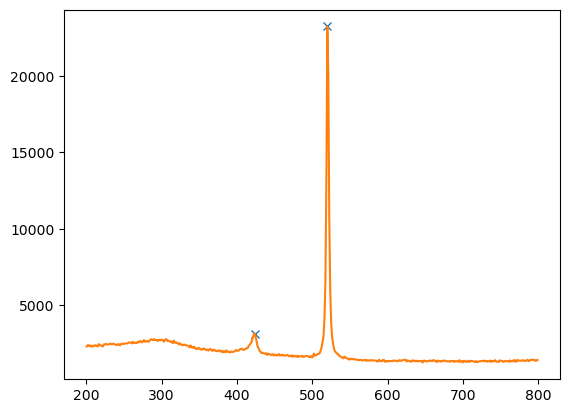

In [8]:
x= x0
y=y0
# yy= y0 - bkg
# min_y= min(yy)
# y= yy - min_y
peaks, _ = find_peaks(y, prominence=300, width=2.5, height=3000)
# peaks, _ = find_peaks(y, prominence=150, width=2)

print(peaks)
plt.plot(x.iloc[peaks], y.iloc[peaks], "x")
plt.plot(x, y)
print(min(y))


#### fit individual peaks (probably not needed, and might not work well)

413.2241074930017 66108.39601563127 74.96255893622717


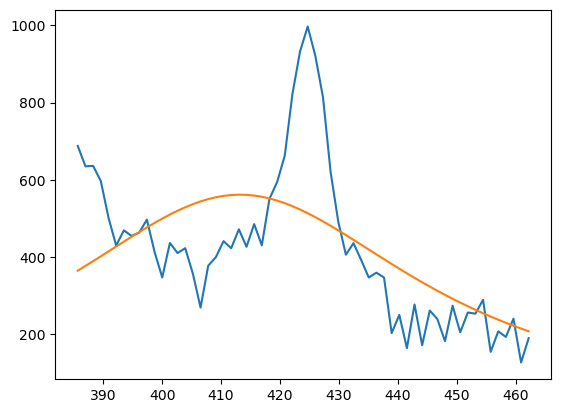

In [187]:
peak_1= peaks[-1]
x_1,y_1 = x[peak_1-30:peak_1+30], y[peak_1-30:peak_1+30]
x_1.reset_index(drop=True, inplace=True)
y_1.reset_index(drop=True, inplace=True)

model= LorentzianModel(prefix='peak_')
pars = model.guess(y_1, x=x_1)
out = model.fit(y_1, pars, x=x_1)
# print(out.fit_report())
center = out.params['peak_center'].value
amplitude = out.params['peak_amplitude'].value
fwhm = out.params['peak_fwhm'].value

plt.plot(x_1, y_1)
plt.plot(x_1, out.best_fit)
print(center, amplitude, fwhm)

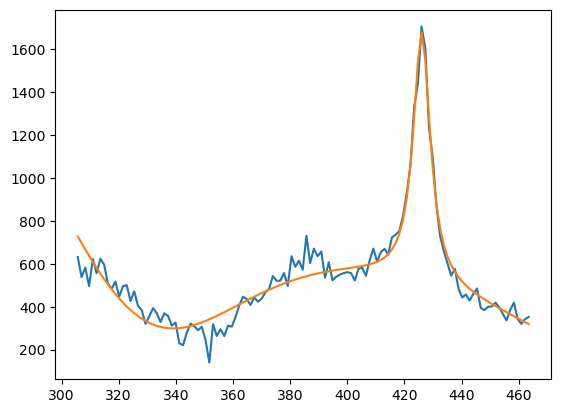

In [164]:
# fit peaks 1, 2 with 2 lorentianz

x_1,y_1 = x[peaks[1]-30:peaks[2]+30], y[peaks[1]-30:peaks[2]+30]
x_1.reset_index(drop=True, inplace=True)
y_1.reset_index(drop=True, inplace=True)

back = LinearModel(prefix='back_')
model1= LorentzianModel(prefix='peak1_')
model2= LorentzianModel(prefix='peak2_')

pars = back.guess(y_1, x=x_1)
pars1 = model1.guess(y_1, x=x_1)
pars2 = model2.guess(y_1, x=x_1)
pars1.update(pars2)
pars1.update(pars)
pars1['peak1_center'].set(value= x.iloc[peaks[1]])
pars1['peak2_center'].set(value= x.iloc[peaks[2]]) #, vary=False)
combined_model = back + model1 + model2
out = combined_model.fit(y_1, pars1, x=x_1)

plt.plot(x_1, y_1)
plt.plot(x_1, out.best_fit)

#### fit all peaks and background
in the range where the peaks are

0
1


{'peak_0': (422.51476955819936, 18184.047839380823, 9.134091366738305),
 'peak_1': (520.3707281253115, 121319.46711970543, 3.286548580114874)}

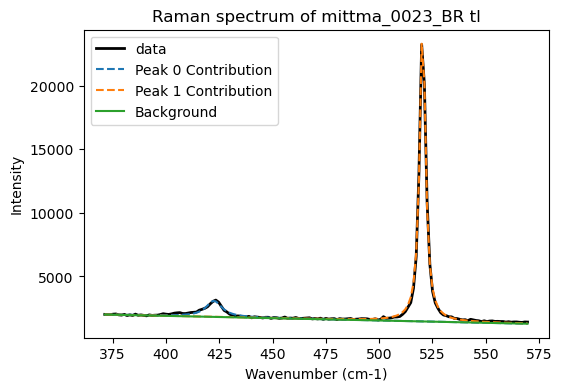

In [9]:
# try to fit all peaks with lorentzian at the same time

x_all, y_all = x[peaks[0]-40:peaks[-1]+40], y[peaks[0]-40:peaks[-1]+40] # cut the data where there are peaks 
x_all.reset_index(drop=True, inplace=True)
y_all.reset_index(drop=True, inplace=True)

back = LinearModel(prefix='back_')
pars = back.guess(y_all, x=x_all)
pars['back_slope'].set(value=0, vary=True)
pars['back_intercept'].set(value=0, vary=True)
models= {}
params = {}
for i in range(len(peaks)):
    print(i)
    models[i]= LorentzianModel(prefix=f'peak{i}_')
    params[f'peak_{i}'] = models[i].guess(y_all, x=x_all)
    pars.update(params[f'peak_{i}'])
    # print(pars)
    pars[f'peak{i}_center'].set(value= x.iloc[peaks[i]], vary=True)  # if fitting is very wrong, set vary=False
    pars[f'peak{i}_amplitude'].set(value= y.iloc[peaks[i]], min=0, max=1000000)
    pars[f'peak{i}_fwhm'].set(value= 10, min=0, max=1000)
    pars[f'peak{i}_height'].set(value= 10, min=0)
    
    # pars[f'peak{i}_sigma'].set(value= 10)
    back += models[i]

out = back.fit(y_all, pars, x=x_all)
# print(out.fit_report()) # print the fit report, with all parameters and their uncertainties

plt.figure(figsize=(6,4))
plt.plot(x_all, y_all, 'k', linewidth=2, label='data')
# plt.plot(x_all, out.best_fit , 'b--',label='fit') # plots all the fit together

# Extract the individual peak parameters to plot them separately
back_model= LinearModel(prefix='back_')
background= back_model.eval(params=out.params, x=x_all)

results= {}
for i in range(len(peaks)):
    center= out.params[f'peak{i}_center'].value
    amplitude= out.params[f'peak{i}_amplitude'].value
    fwhm= 2*out.params[f'peak{i}_sigma'].value
    results[f'peak_{i}']= (center, amplitude, fwhm)

    peak = models[i].eval(params=out.params, x=x_all)
    plt.plot(x_all, peak+background, '--'  ,label=f'Peak {i} Contribution')

plt.plot(x_all, background,label='Background')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title(f'Raman spectrum of {sample_name} {samples_to_analyse[n]}')
plt.legend()

# plt.savefig(os.path.join(folder, f'{sample_name}_{samples_to_analyse[n]}_raman_fit.png'), dpi=300)
display(results)
plt.show()

#### save results in a txt file for all the points measured 

In [509]:
#save theresult to a PD dataframe
df = pd.DataFrame(results).T
df.columns = ['center', 'amplitude', 'fwhm']

# add peak information to the results dictionary

# all_results={}   # initialize the dictionary ( do it once, for the first measurement of a sample)
all_results[samples_to_analyse[n]] = df
display(all_results)

{'bl':             center      amplitude         fwhm
 peak_0  301.720703  480215.576859   265.668072
 peak_1  423.392578      75.152806  2732.606245
 peak_2  519.916016  341211.130664     3.617997,
 'br1':             center      amplitude       fwhm
 peak_0  299.080078  194244.399646  98.990776
 peak_1  424.689453    7112.554737   5.666598
 peak_2  519.916016  274918.387957   3.497055,
 'tl':             center      amplitude       fwhm
 peak_0  305.679688   50337.100862  61.951784
 peak_1  423.392578   18087.160143   9.006448
 peak_2  519.916016  123680.183711   3.543169,
 'tr':             center      amplitude        fwhm
 peak_0  289.826172  159362.430770  117.352106
 peak_1  423.392578   22106.375754    9.405105
 peak_2  519.916016  125983.556052    3.560131,
 '':             center      amplitude       fwhm
 peak_0  304.361328   34269.113672  41.672872
 peak_1  423.392578   28929.066369   8.933968
 peak_2  519.916016  217749.545715   3.555718}

In [510]:
# save the results to a pickle file
with open(os.path.join(folder, f'{sample_name}_raman_fit_results.pkl'), 'wb') as f:
    pickle.dump(all_results, f)

In [511]:
# save the results to a text file
with open(os.path.join(folder, f'{sample_name}_raman_fit_results.txt'), 'w') as f:
    for key, value in all_results.items():
        f.write(f'{key}:\n')
        f.write(f'{value}\n\n')

#### treatment of fitted data
get averages, and other parameters if you want

In [561]:
folder= r"Z:\P110143-phosphosulfides-Andrea\Data\Samples\mittma_0011_Cu\Raman"
sample_name= 'mittma_0011_BR'

with open(os.path.join(folder, f'{sample_name}_raman_fit_results.pkl'), 'rb') as f:
    all_results = pickle.load(f)

display(all_results)

{'bl':             center     amplitude           fwhm
 peak_0  301.720703  1.586358e+06  240668.805527
 peak_1  366.103516  4.379116e+04      21.278778
 peak_2  388.296875  8.505911e+04      17.074358
 peak_3  519.916016  5.299948e+05       3.737965,
 'br1':             center      amplitude       fwhm
 peak_0  303.041016   35661.110748  26.132789
 peak_1  388.296875  222597.403145  14.983720
 peak_2  519.916016  459680.403885   3.633184,
 'tl':             center      amplitude       fwhm
 peak_0  303.041016   19497.046457  18.607988
 peak_1  386.994141  165793.293769  22.047148
 peak_2  519.916016  470944.157623   3.633268,
 'tr':             center      amplitude       fwhm
 peak_0  303.041016    3754.195973   7.803778
 peak_1  388.296875  163485.524067  27.306698
 peak_2  519.916016  350030.011949   3.601466,
 '':             center      amplitude       fwhm
 peak_0  300.400391   36875.142507  29.441870
 peak_1  388.296875  225344.207744  15.743979
 peak_2  519.916016  487459.9796

In [562]:
# 
all_results['bl'].drop('peak_1', inplace=True, axis=0)
# all_results[''].drop('peak_2', inplace=True, axis=0)

for key, df in all_results.items():
    i=0
    df['relative_intensity'] = df['amplitude']/df['amplitude'].iloc[-1]
    for peak in df.index:
        # df.dropindex(peak, inplace=True)
        df.rename(index={peak: f'peak_{i}'}, inplace=True)
        i+=1

display(all_results)

{'bl':             center     amplitude           fwhm  relative_intensity
 peak_0  301.720703  1.586358e+06  240668.805527            2.993158
 peak_1  388.296875  8.505911e+04      17.074358            0.160490
 peak_2  519.916016  5.299948e+05       3.737965            1.000000,
 'br1':             center      amplitude       fwhm  relative_intensity
 peak_0  303.041016   35661.110748  26.132789            0.077578
 peak_1  388.296875  222597.403145  14.983720            0.484244
 peak_2  519.916016  459680.403885   3.633184            1.000000,
 'tl':             center      amplitude       fwhm  relative_intensity
 peak_0  303.041016   19497.046457  18.607988            0.041400
 peak_1  386.994141  165793.293769  22.047148            0.352044
 peak_2  519.916016  470944.157623   3.633268            1.000000,
 'tr':             center      amplitude       fwhm  relative_intensity
 peak_0  303.041016    3754.195973   7.803778            0.010725
 peak_1  388.296875  163485.524067  

In [563]:
# Initialize dictionaries to store the sum of centers, amplitudes, and fwhm
sum_centers = {}
sum_amplitudes = {}
sum_fwhm = {}
sum_relative_intensity = {}
count = {}

# Iterate through all results to accumulate the sums
for key, df in all_results.items():
    for peak in df.index:
        if peak not in sum_centers:
            sum_centers[peak] = 0
            sum_amplitudes[peak] = 0
            sum_fwhm[peak] = 0
            sum_relative_intensity[peak] = 0
            count[peak] = 0
        sum_centers[peak] += df.loc[peak, 'center']
        sum_amplitudes[peak] += df.loc[peak, 'amplitude']
        sum_fwhm[peak] += df.loc[peak, 'fwhm']
        sum_relative_intensity[peak] += df.loc[peak, 'relative_intensity']
        count[peak] += 1

# Calculate the averages
averages = {
    'center': {peak: sum_centers[peak] / count[peak] for peak in sum_centers},
    'amplitude': {peak: sum_amplitudes[peak] / count[peak] for peak in sum_amplitudes},
    'fwhm': {peak: sum_fwhm[peak] / count[peak] for peak in sum_fwhm},
    'relative_intensity': {peak: sum_relative_intensity[peak] / count[peak] for peak in sum_relative_intensity}
}

# Convert the averages dictionary to a DataFrame
averages_df = pd.DataFrame(averages)
display(averages_df)

,center,amplitude,fwhm,relative_intensity
peak_0,302.248828,336429.145613,48150.158390,0.639702
peak_1,388.036328,172455.906881,19.431181,0.385225
peak_2,519.916016,459621.868050,3.653084,1.000000
